# Strojenie modelu BERT-base na danych *cyberbullying*

## Biblioteki

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, AutoTokenizer
import torch
from transformers import BertForSequenceClassification, BertForTokenClassification, Trainer, TrainingArguments,  DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, confusion_matrix
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.preprocessing import StandardScaler
import kagglehub
from datasets import Dataset, DatasetDict
import json
from excel2json import convert_from_file
import seaborn as sns

## Załadowanie danych

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### Teksty

In [3]:
# path = kagglehub.dataset_download("waalbannyantudre/hate-speech-detection-curated-dataset")

# print("Path to dataset files:", path)

In [4]:
df = pd.read_csv('HateSpeechDataset.csv')
df['text'] = df['Content']
df = df.drop(columns=['Content_int', 'Content'])
df = df[df['Label'] != 'Label']
display(df.head())

,Label,text
0,1,denial of normal the con be asked to comment o...
1,1,just by being able to tweet this insufferable ...
2,1,that is retarded you too cute to be single tha...
3,1,thought of a real badass mongol style declarat...
4,1,afro american basho


In [5]:
texts_train, texts_test, text_labels_train, text_labels_test = train_test_split(
    df['text'], df['Label'], test_size=0.2, random_state=42
)

In [6]:
df_train = pd.DataFrame()
df_train['text'] = texts_train
df_train['LABEL'] = text_labels_train

df_test = pd.DataFrame()
df_test['text'] = texts_test
df_test['LABEL'] = text_labels_test

In [7]:
# min_class_count = df_train['LABEL'].value_counts().min()
min_class_count_train = 1000
min_class_count_test = 500

df_train_balanced = df_train.groupby('LABEL').apply(lambda x: x.sample(min_class_count_train)).reset_index(drop=True)
df_test_balanced = df_test.groupby('LABEL').apply(lambda x: x.sample(min_class_count_test)).reset_index(drop=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_11332\4132669510.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_balanced = df_train.groupby('LABEL').apply(lambda x: x.sample(min_class_count_train)).reset_index(drop=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_11332\4132669510.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_test_balanced = df_test.groupby('LABEL').apply(lambda x: x.sample

In [8]:
train_json = df_train_balanced.to_json(orient='records')
test_json = df_test_balanced.to_json(orient='records')


train_dataset = Dataset.from_list(json.loads(train_json))
test_dataset = Dataset.from_list(json.loads(test_json))


dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

In [9]:
print(dataset['train'])

Dataset({
    features: ['text', 'LABEL'],
    num_rows: 2000
})


In [10]:
print(dataset['test'])

Dataset({
    features: ['text', 'LABEL'],
    num_rows: 1000
})


In [11]:
for entry in dataset['train'].select(range(5)):
    print('TEXT: {} \nLABEL: {}\n'.format(entry['text'], entry['LABEL']))

TEXT: ammonia hi i have tagged your addition of ammonia to list of arabic loanwords in english as as neither the oxford english dictionary nor the articles jair in aryan or sal ammonia give any support to your claim i did not delete it outright as your edit history suggests that you are a responsible editor do you have a reference 
LABEL: 0

TEXT: utc austin out of l seven what a slut the one i forgot there were also compilations like reflections and austin out both of which featured older hits along with at least one new song rick had another album who is name escapes me available only as an import and a final studio album released after his death i will try to get some of this together when i get time 
LABEL: 0

TEXT: frankly this article should be deleted not rewritten you want to consider the limit of in an article on limits i do not think it belongs to the positional system either all positional systems are based on approximations 
LABEL: 0

TEXT: update most links with requested 

In [12]:
train_counts = pd.DataFrame({'Sentiment': dataset['train']['LABEL']})
train_counts = train_counts.groupby('Sentiment').size().reset_index(name='train_set')

test_counts = pd.DataFrame({'Sentiment': dataset['test']['LABEL']})
test_counts = test_counts.groupby('Sentiment').size().reset_index(name='test_set')

display(train_counts.merge(test_counts, on='Sentiment'))

,Sentiment,train_set,test_set
0,0,1000,500
1,1,1000,500


### Tokeny

## Strojenie modelu dla zadania klasyfikacji tekstu

In [13]:
sorted_labels = sorted(set(dataset['train']['LABEL']))
label2id = dict(zip(sorted_labels, range(0, len(sorted_labels))))
id2label = dict(zip(range(0, len(sorted_labels)), sorted_labels))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                                    num_labels=len(label2id),
                                                                    label2id=label2id,
                                                                    id2label=id2label)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
def preprocess_function(examples):
    """Preprocess the dataset by returning tokenized examples."""
    tokens = tokenizer(examples["text"], padding="max_length", truncation=True)
    tokens['label'] = [label2id[l] for l in examples["LABEL"]]
    return tokens

splits = ['train', 'test']

tokenized_ds = {} 

for split in splits:
    tokenized_ds[split] = dataset[split].map(preprocess_function, batched=True)

print(tokenized_ds)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

{'train': Dataset({
    features: ['text', 'LABEL', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 2000
}), 'test': Dataset({
    features: ['text', 'LABEL', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 1000
})}


In [15]:
print("A tokenized training input example:")
print(tokenized_ds["train"][0]["input_ids"])
print("\n")
print("A tokenized training label example:")
print(tokenized_ds["train"][0]["label"])
print(tokenized_ds["train"][0]['attention_mask'])

A tokenized training input example:
[101, 25874, 7632, 1045, 2031, 26610, 2115, 2804, 1997, 25874, 2000, 2862, 1997, 5640, 5414, 22104, 1999, 2394, 2004, 2004, 4445, 1996, 4345, 2394, 9206, 4496, 1996, 4790, 17410, 2099, 1999, 26030, 2030, 16183, 25874, 2507, 2151, 2490, 2000, 2115, 4366, 1045, 2106, 2025, 3972, 12870, 2009, 13848, 2004, 2115, 10086, 2381, 6083, 2008, 2017, 2024, 1037, 3625, 3559, 2079, 2017, 2031, 1037, 4431, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [16]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()*100, "f1": f1_score(labels, predictions, labels=[0, 1], pos_label=1)}



trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir="bert-lora",
        learning_rate=2e-3,
        # Reduce the batch size if you don't have enough memory
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        num_train_epochs=10,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    ),
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

print("Starting to train...")
trainer.train()

d:\Python\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\DELL\AppData\Local\Temp\ipykernel_11332\1893380289.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting to train...


  0%|          | 0/10000 [00:00<?, ?it/s]

d:\Python\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


{'loss': 1.1965, 'grad_norm': 14.66075325012207, 'learning_rate': 0.0019, 'epoch': 0.5}
{'loss': 1.1908, 'grad_norm': 5.211457252502441, 'learning_rate': 0.0018000000000000002, 'epoch': 1.0}


  0%|          | 0/500 [00:00<?, ?it/s]

{'eval_loss': 0.7113090753555298, 'eval_accuracy': 50.0, 'eval_f1': 0.0, 'eval_runtime': 35.2992, 'eval_samples_per_second': 28.329, 'eval_steps_per_second': 14.165, 'epoch': 1.0}
{'loss': 1.0071, 'grad_norm': 5.977087020874023, 'learning_rate': 0.0017, 'epoch': 1.5}
{'loss': 1.0936, 'grad_norm': 15.37193489074707, 'learning_rate': 0.0016, 'epoch': 2.0}


  0%|          | 0/500 [00:00<?, ?it/s]

{'eval_loss': 0.6933939456939697, 'eval_accuracy': 50.0, 'eval_f1': 0.6666666666666666, 'eval_runtime': 37.7499, 'eval_samples_per_second': 26.49, 'eval_steps_per_second': 13.245, 'epoch': 2.0}
{'loss': 1.0322, 'grad_norm': 8.420806884765625, 'learning_rate': 0.0015, 'epoch': 2.5}
{'loss': 1.1013, 'grad_norm': 17.15287971496582, 'learning_rate': 0.0014, 'epoch': 3.0}


  0%|          | 0/500 [00:00<?, ?it/s]

{'eval_loss': 0.9891204237937927, 'eval_accuracy': 50.0, 'eval_f1': 0.0, 'eval_runtime': 35.5039, 'eval_samples_per_second': 28.166, 'eval_steps_per_second': 14.083, 'epoch': 3.0}
{'loss': 1.1111, 'grad_norm': 35.21025466918945, 'learning_rate': 0.0013000000000000002, 'epoch': 3.5}
{'loss': 0.9674, 'grad_norm': 19.31232452392578, 'learning_rate': 0.0012, 'epoch': 4.0}


  0%|          | 0/500 [00:00<?, ?it/s]

{'eval_loss': 1.7038660049438477, 'eval_accuracy': 50.0, 'eval_f1': 0.0, 'eval_runtime': 35.6989, 'eval_samples_per_second': 28.012, 'eval_steps_per_second': 14.006, 'epoch': 4.0}
{'loss': 1.0623, 'grad_norm': 18.10812759399414, 'learning_rate': 0.0011, 'epoch': 4.5}
{'loss': 0.9641, 'grad_norm': 26.196575164794922, 'learning_rate': 0.001, 'epoch': 5.0}


  0%|          | 0/500 [00:00<?, ?it/s]

{'eval_loss': 0.6999880075454712, 'eval_accuracy': 50.0, 'eval_f1': 0.6666666666666666, 'eval_runtime': 35.6714, 'eval_samples_per_second': 28.034, 'eval_steps_per_second': 14.017, 'epoch': 5.0}
{'loss': 0.8763, 'grad_norm': 5.8465142250061035, 'learning_rate': 0.0009000000000000001, 'epoch': 5.5}
{'loss': 0.9083, 'grad_norm': 17.009414672851562, 'learning_rate': 0.0008, 'epoch': 6.0}


  0%|          | 0/500 [00:00<?, ?it/s]

{'eval_loss': 0.7039238810539246, 'eval_accuracy': 50.0, 'eval_f1': 0.0, 'eval_runtime': 35.6767, 'eval_samples_per_second': 28.03, 'eval_steps_per_second': 14.015, 'epoch': 6.0}
{'loss': 0.9341, 'grad_norm': 10.664372444152832, 'learning_rate': 0.0007, 'epoch': 6.5}
{'loss': 0.8685, 'grad_norm': 10.178929328918457, 'learning_rate': 0.0006, 'epoch': 7.0}


  0%|          | 0/500 [00:00<?, ?it/s]

{'eval_loss': 0.8265249729156494, 'eval_accuracy': 50.0, 'eval_f1': 0.0, 'eval_runtime': 38.5072, 'eval_samples_per_second': 25.969, 'eval_steps_per_second': 12.985, 'epoch': 7.0}
{'loss': 0.839, 'grad_norm': 5.6103668212890625, 'learning_rate': 0.0005, 'epoch': 7.5}
{'loss': 0.8048, 'grad_norm': 17.159181594848633, 'learning_rate': 0.0004, 'epoch': 8.0}


  0%|          | 0/500 [00:00<?, ?it/s]

{'eval_loss': 0.705240786075592, 'eval_accuracy': 50.0, 'eval_f1': 0.6666666666666666, 'eval_runtime': 38.7819, 'eval_samples_per_second': 25.785, 'eval_steps_per_second': 12.893, 'epoch': 8.0}
{'loss': 0.7768, 'grad_norm': 9.220349311828613, 'learning_rate': 0.0003, 'epoch': 8.5}
{'loss': 0.7534, 'grad_norm': 5.680224418640137, 'learning_rate': 0.0002, 'epoch': 9.0}


  0%|          | 0/500 [00:00<?, ?it/s]

{'eval_loss': 0.702836275100708, 'eval_accuracy': 50.0, 'eval_f1': 0.0, 'eval_runtime': 37.9688, 'eval_samples_per_second': 26.337, 'eval_steps_per_second': 13.169, 'epoch': 9.0}
{'loss': 0.7563, 'grad_norm': 16.61347198486328, 'learning_rate': 0.0001, 'epoch': 9.5}
{'loss': 0.7402, 'grad_norm': 8.541726112365723, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/500 [00:00<?, ?it/s]

{'eval_loss': 0.6937728524208069, 'eval_accuracy': 50.0, 'eval_f1': 0.6666666666666666, 'eval_runtime': 38.3537, 'eval_samples_per_second': 26.073, 'eval_steps_per_second': 13.037, 'epoch': 10.0}
{'train_runtime': 3111.0206, 'train_samples_per_second': 6.429, 'train_steps_per_second': 3.214, 'train_loss': 0.9491955932617188, 'epoch': 10.0}


TrainOutput(global_step=10000, training_loss=0.9491955932617188, metrics={'train_runtime': 3111.0206, 'train_samples_per_second': 6.429, 'train_steps_per_second': 3.214, 'total_flos': 5262221107200000.0, 'train_loss': 0.9491955932617188, 'epoch': 10.0})

In [20]:
noun_model_path = 'sentence_model-weights/'
model.save_pretrained(noun_model_path)

## Strojenie modelu dla zadanie klasyfikacji tokenów

In [18]:
# # Zapisanie modelu
# noun_model_path = 'noun_model-weights/'
# model_noun.save_pretrained(noun_model_path)

## Ocena jakości predyckji

### Teksty

In [22]:
predictions = trainer.predict(tokenized_ds['test'])

predicted_labels = predictions.predictions.argmax(axis=1)  
true_labels = predictions.label_ids 
metrics = predictions.metrics

print("Wyniki:")
print("-" * 20)
for key, value in metrics.items():
    print(f"{key.replace('_', ' ').title()}: {value:.4f}" if isinstance(value, float) else f"{key.replace('_', ' ').title()}: {value}")

  0%|          | 0/500 [00:00<?, ?it/s]

Wyniki:
--------------------
Test Loss: 0.6934
Test Accuracy: 50.0000
Test F1: 0.6667
Test Runtime: 34.9923
Test Samples Per Second: 28.5780
Test Steps Per Second: 14.2890


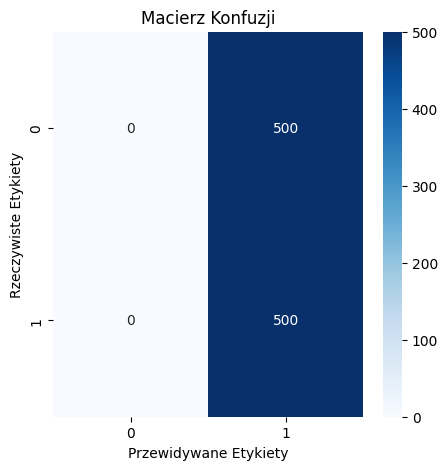

In [32]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

labels = np.unique(true_labels)  
confusion_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=labels, yticklabels=labels)
plt.title('Macierz Konfuzji')
plt.xlabel('Przewidywane Etykiety')
plt.ylabel('Rzeczywiste Etykiety')
plt.show()

### Tokeny

## Wizualizacja przestrzeni wektorowej

### Teksty

In [23]:
def embed_text(examples):
    tokens = tokenizer(examples, padding="max_length", truncation=True)
    return tokens

def wrap_text(text, width=40):
    return '<br>'.join([text[i:i+width] for i in range(0, len(text), width)])


In [24]:
text = pd.DataFrame(tokenized_ds['test']['text'], columns=['text'])
text['text'] = text['text'].apply(wrap_text)

embeddings = embed_text(dataset['test']['text'])

#### PCA

In [25]:
pca = PCA(n_components=2).fit_transform(embeddings['input_ids'])

df_pca = pd.DataFrame(pca, columns=['PCA1', 'PCA2'])
df_pca['Predicted Label']  = [predicted_labels[i] for i in range(len(predicted_labels))]
df_pca['Text'] = text['text']
df_pca['True label'] = [true_labels[i] for i in range(len(true_labels))]

fig = px.scatter(df_pca, x="PCA1", y="PCA2", color="Predicted Label", hover_data={'Text': True, 'True label': True}, title="Wizualizacja przestrzeni wektorowej prób testowych",
                labels={"PC1": "Pierwsza składowa główna", "PC2": "Druga składowa główna"})
fig.show()

#### TSNE

In [26]:
scaler = StandardScaler()
scaled_vectors = scaler.fit_transform(embeddings['input_ids'])

tsne = TSNE(n_components=2, random_state=42).fit_transform(scaled_vectors)

df_tsne = pd.DataFrame(tsne, columns=['x', 'y'])
df_tsne['Predicted Label']  = [predicted_labels[i] for i in range(len(predicted_labels))]
df_tsne['Text'] = text['text']
df_tsne['True label'] = [true_labels[i] for i in range(len(true_labels))]

fig = px.scatter(df_tsne, x='x', y='y', color='Predicted Label', hover_data={'Text': True, 'True label': True}, title="Wizualizacja przestrzeni wektorowej prób testowych")
fig.show()

### Tokeny

#### PCA

#### TSNE